In [1]:
import time
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import cv2
import shutil

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Get the computing hardware
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [2]:
# classes = os.listdir(r'..\SIDTA')
classes = os.listdir(r'D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\TTSID')
classes

['Lu_points', 'Rest_points', 'Traveling_points']

In [3]:
# dataset_path = r'..\SIDTA'
# target_path = r'..\Train_val_split'
dataset_path = r'D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\TTSID'
target_path = r'D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\train_val_split'

## Load image classification dataset

In [6]:
import random
import shutil

test_frac = 0.2  # Test set ratio
random.seed(123)  # Random seed for reproducibility
df = pd.DataFrame()
print('{:^18} {:^18} {:^18}'.format('Class', 'Training data num', 'Test data num'))

for truck_point in classes:  # Traverse each class
    # Read all image filenames for this class
    old_dir = os.path.join(dataset_path, truck_point)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename)  # Randomly shuffle

    # Divide into training set and test set
    testset_numer = int(len(images_filename) * test_frac)  # Number of test set images
    testset_images = images_filename[:testset_numer]  # Get the filenames of test set images to be moved to the test directory
    trainset_images = images_filename[testset_numer:]  # Get the filenames of training set images to be moved to the train directory

    # Move images to the test directory
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, truck_point, image)  # Get the original file path
        new_test_path = os.path.join(target_path, 'val', truck_point, image)  # Get the new file path for the test directory
        # Create the output directory if it doesn't exist
        if not os.path.exists(os.path.join(target_path, 'val', truck_point)):
            os.makedirs(os.path.join(target_path, 'val', truck_point))
        shutil.move(old_img_path, new_test_path)  # Move the file

    # Move images to the train directory
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, truck_point, image)  # Get the original file path
        new_train_path = os.path.join(target_path, 'train', truck_point, image)  # Get the new file path for the train directory
        # Create the output directory if it doesn't exist
        if not os.path.exists(os.path.join(target_path, 'train', truck_point)):
            os.makedirs(os.path.join(target_path, 'train', truck_point))
        shutil.move(old_img_path, new_train_path)  # Move the file

    # Delete the old folder
    assert len(os.listdir(old_dir)) == 0  # Ensure that all images in the old folder have been moved away
    # shutil.rmtree(old_dir)  # Delete the folder

    # Output the data count for each class in a neat way
    print('{:^18} {:^18} {:^18}'.format(truck_point, len(trainset_images), len(testset_images)))

    # Save to the dataframe
    df = df.append({'class': truck_point, 'trainset': len(trainset_images), 'testset': len(testset_images)},
                   ignore_index=True)

# Rename the dataset folder
# shutil.move(dataset_path, dataset_name + '_split')

# Dataset class count statistics table, exported as a csv file
# df['total'] = df['trainset'] + df['testset']
# df.to_csv('data_stats.csv', index=False)


      Class        Training data num    Test data num   
    Lu_points             800                200        
   Rest_points            800                200        
 Traveling_points         800                200        


In [8]:
from torchvision import transforms

# Preprocessing for the training set: scale and crop, data augmentation, convert to Tensor, and normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Preprocessing for the test set using RCTN: resize, crop, convert to Tensor, and normalization
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# '''for inception-v3'''
# train_transform = transforms.Compose([
#     transforms.Resize(299),
#     transforms.CenterCrop(299),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])
#
# test_transform = transforms.Compose([
#     transforms.Resize(299),
#     transforms.CenterCrop(299),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

In [9]:
train_path = os.path.join(target_path, 'train')
test_path = os.path.join(target_path, 'val')
print('Training set path:', train_path)
print('Test set path:', test_path)

from torchvision import datasets
# Load the training set
train_dataset = datasets.ImageFolder(train_path, train_transform)
# Load the test set
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('Number of images in the training set:', len(train_dataset))
print('Number of classes:', len(train_dataset.classes))
print('Class names:', train_dataset.classes)
print('Number of images in the test set:', len(test_dataset))
print('Number of classes:', len(test_dataset.classes))
print('Class names:', test_dataset.classes)

Training set path: D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\train_val_split\train
Test set path: D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\train_val_split\val
Number of images in the training set: 2400
Number of classes: 3
Class names: ['Lu_points', 'Rest_points', 'Traveling_points']
Number of images in the test set: 600
Number of classes: 3
Class names: ['Lu_points', 'Rest_points', 'Traveling_points']


## Category and index number Mapping dictionary

In [10]:
# Class names
class_names = train_dataset.classes
n_class = len(class_names)

# Mapping dictionary: class names to index numbers
train_dataset.class_to_idx

# Reverse mapping dictionary: index numbers to class names
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [14]:
np.save('idx_to_labels.npy', idx_to_labels)

## Define the DataLoader

In [25]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Data loaders for the training set
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# Data loaders for the test set
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

## Toolkits to use for import training

In [45]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

### Migration learning: fine-tuning training all layers

In [55]:
# ShuffleNet V2
model = models.shufflenet_v2_x2_0(pretrained=True)  # Load the pre-trained model
# Modify the number of output features of the fully connected layer
model.heads.head = nn.Linear(model.heads.head.in_features, n_class)

optimizer = optim.Adam(model.parameters())

In [12]:
# ResNet50
model = models.resnet50(pretrained=True)  # Load the pre-trained model
# Modify the number of output features of the fully connected layer
model.fc = nn.Linear(model.fc.in_features, n_class)

optimizer = optim.Adam(model.parameters())

In [12]:
# Inception V3
model = models.inception_v3(pretrained=True)  # Load the pre-trained model
# Modify the number of output features of the fully connected layer
model.fc = nn.Linear(model.fc.in_features, n_class)

optimizer = optim.Adam(model.parameters())

## Training configurations

In [46]:
model = model.to(device)

# Cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Number of training epochs
EPOCHS = 30

# Learning rate reduction strategy
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## Training on the training set

In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [19]:
def train_one_batch(images, labels):
    '''
    Train one batch of data and return the training log for the current batch
    '''

    # Get the data and labels for a batch
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images) # Input the model and execute forward prediction
    loss = criterion(outputs, labels) # Compute the average cross-entropy loss for each sample in the current batch

    # Optimize and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Get the label categories and predicted categories for the current batch
    _, preds = torch.max(outputs, 1) # Get the predicted category for all images in the current batch
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # Calculate classification evaluation metrics
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    # log_train['train_precision'] = precision_score(labels, preds, average='macro')
    # log_train['train_recall'] = recall_score(labels, preds, average='macro')
    # log_train['train_f1-score'] = f1_score(labels, preds, average='macro')

    return log_train

## Evaluate on the entire test set

In [22]:
def evaluate_testset():
    '''
    Evaluate on the entire test set and return classification evaluation metrics log
    '''

    loss_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in test_loader: # generate a batch of data and labels
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # input to the model and execute forward prediction

            # get the label and prediction for the entire test set
            _, preds = torch.max(outputs, 1) # get the predicted class for all images in the current batch
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # compute the average cross-entropy loss value for each sample in the current batch
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)

    log_test = {}
    log_test['epoch'] = epoch

    # calculate classification evaluation metrics
    log_test['test_loss'] = np.mean(loss)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')

    return log_test

def evaluate_train():
    '''
    Evaluate on the entire train set and return classification evaluation metrics log
    '''

    loss_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in train_loader: # generate a batch of data and labels
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # input to the model and execute forward prediction

            # get the label and prediction for the entire train set
            _, preds = torch.max(outputs, 1) # get the predicted class for all images in the current batch
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # compute the average cross-entropy loss value for each sample in the current batch
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)

    log_test = {}
    log_test['epoch'] = epoch

    # calculate classification evaluation metrics
    log_test['test_loss'] = np.mean(loss)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')

    return log_test

## Keep a log before training begins

In [47]:
epoch = 0
batch_idx = 0
best_test_accuracy = 0

In [48]:
# Train log - training set
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log.append(log_train, ignore_index=True)

In [49]:
df_train_log

,epoch,batch,train_loss,train_accuracy
0,0,0,0.53515404,0.8125


In [50]:
# Test set training log
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log.append(log_test, ignore_index=True)

In [51]:
df_test_log

,epoch,test_loss,test_accuracy,test_precision,test_recall,test_f1-score
0,0.0,0.00002,0.333333,0.111297,0.333333,0.166875


## Training

In [52]:
for epoch in range(1, EPOCHS+1):

    print(f'Epoch {epoch}/{EPOCHS}')

    ## Training phase
    model.train()
    for images, labels in tqdm(train_loader):
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log.append(log_train, ignore_index=True)

    lr_scheduler.step()

    ## Testing phase
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log.append(log_test, ignore_index=True)

    # Save the latest best model file
    if log_test['test_accuracy'] > best_test_accuracy:
        # Delete the old best model file (if any)
        old_best_checkpoint_path = 'checkpoints/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # Save the new best model file
        new_best_checkpoint_path = 'checkpoints/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('Saved new best model', 'checkpoints/best-{:.3f}.pth'.format(best_test_accuracy))
        best_test_accuracy = log_test['test_accuracy']

# df_train_log.to_csv('Training log - Training set.csv', index=False)
# df_test_log.to_csv('Training log - Testing set.csv', index=False)

Epoch 1/30


100%|██████████| 75/75 [01:05<00:00,  1.14it/s]


Saved new best model checkpoints/best-0.000.pth
Epoch 2/30


100%|██████████| 75/75 [00:49<00:00,  1.51it/s]


Saved new best model checkpoints/best-0.503.pth
Epoch 3/30


100%|██████████| 75/75 [00:48<00:00,  1.53it/s]


Epoch 4/30


100%|██████████| 75/75 [00:49<00:00,  1.53it/s]


Saved new best model checkpoints/best-0.857.pth
Epoch 5/30


100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


Saved new best model checkpoints/best-0.888.pth
Epoch 6/30


100%|██████████| 75/75 [00:48<00:00,  1.53it/s]


Saved new best model checkpoints/best-0.910.pth
Epoch 7/30


100%|██████████| 75/75 [00:48<00:00,  1.53it/s]


Epoch 8/30


100%|██████████| 75/75 [00:47<00:00,  1.57it/s]


Epoch 9/30


100%|██████████| 75/75 [00:49<00:00,  1.53it/s]


Saved new best model checkpoints/best-0.947.pth
Epoch 10/30


100%|██████████| 75/75 [00:48<00:00,  1.53it/s]


Saved new best model checkpoints/best-0.952.pth
Epoch 11/30


100%|██████████| 75/75 [00:48<00:00,  1.55it/s]


Saved new best model checkpoints/best-0.967.pth
Epoch 12/30


100%|██████████| 75/75 [00:49<00:00,  1.53it/s]


Epoch 13/30


100%|██████████| 75/75 [00:48<00:00,  1.56it/s]


Epoch 14/30


100%|██████████| 75/75 [00:47<00:00,  1.57it/s]


Epoch 15/30


100%|██████████| 75/75 [00:49<00:00,  1.52it/s]


Saved new best model checkpoints/best-0.970.pth
Epoch 16/30


100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


Epoch 17/30


100%|██████████| 75/75 [00:49<00:00,  1.53it/s]


Epoch 18/30


100%|██████████| 75/75 [00:48<00:00,  1.55it/s]


Saved new best model checkpoints/best-0.973.pth
Epoch 19/30


100%|██████████| 75/75 [00:53<00:00,  1.41it/s]


Epoch 20/30


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch 21/30


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Saved new best model checkpoints/best-0.975.pth
Epoch 22/30


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch 23/30


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch 24/30


100%|██████████| 75/75 [01:04<00:00,  1.16it/s]


Epoch 25/30


100%|██████████| 75/75 [01:06<00:00,  1.14it/s]


Epoch 26/30


100%|██████████| 75/75 [01:04<00:00,  1.15it/s]


Epoch 27/30


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch 28/30


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


Epoch 29/30


100%|██████████| 75/75 [03:20<00:00,  2.67s/it]


Epoch 30/30


100%|██████████| 75/75 [03:20<00:00,  2.68s/it]


## Evaluate on a test set

In [53]:
loss_list = []
labels_list = []
preds_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        loss = criterion(outputs, labels)
        loss = loss.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        loss_list.append(loss)
        labels_list.extend(labels)
        preds_list.extend(preds)

log_test = {}
log_test['test_loss'] = np.mean(loss)
log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')

In [54]:
model.eval()
print(evaluate_train())

{'epoch': 30, 'test_loss': 0.053181097, 'test_accuracy': 0.9766666666666667, 'test_precision': 0.9767156659252341, 'test_recall': 0.9766666666666666, 'test_f1-score': 0.976657330345328}


## Classification observation results

In [55]:
# Define the path of the dataset folder
from torchvision import datasets

# Load the test dataset
test_dataset = datasets.ImageFolder(test_path, test_transform)
print('Number of images in test dataset:', len(test_dataset))
print('Number of classes:', len(test_dataset.classes))
print('Class names:', test_dataset.classes)

# Get the class names
classes = list(idx_to_labels.values())
print(classes)

Number of images in test dataset: 600
Number of classes: 3
Class names: ['Lu_points', 'Rest_points', 'Traveling_points']
['Lu_points', 'Rest_points', 'Traveling_points']


In [56]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
img_paths = [each[0] for each in test_dataset.imgs]

In [58]:
# Create an empty DataFrame
df = pd.DataFrame()

# Add a column for image paths
df['Image Path'] = img_paths

# Add a column for annotated class IDs
df['Annotated Class ID'] = test_dataset.targets

# Add a column for annotated class names by looking up the class ID in the mapping dictionary
df['Annotated Class Name'] = [idx_to_labels[ID] for ID in test_dataset.targets]

In [59]:
# Record top-n prediction results
n = 3

In [60]:
# Create an empty DataFrame for prediction results
df_pred = pd.DataFrame()

# Iterate over each row in the DataFrame
for idx, row in tqdm(df.iterrows()):
    # Load and preprocess the image
    img_path = row['Image Path']
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_transform(img_pil).unsqueeze(0).to(device)

    # Make a forward prediction on the image
    pred_logits = model(input_img)
    pred_softmax = F.softmax(pred_logits, dim=1)

    # Create a dictionary to store the prediction results
    pred_dict = {}

    # Record the top-n predicted IDs and names
    top_n = torch.topk(pred_softmax, n)
    pred_ids = top_n[1].cpu().detach().numpy().squeeze()
    for i in range(1, n+1):
        pred_dict['Top-{} Predicted ID'.format(i)] = pred_ids[i-1]
        pred_dict['Top-{} Predicted Name'.format(i)] = idx_to_labels[pred_ids[i-1]]
    pred_dict['Top-n Predicted Correct'] = row['Annotated Class ID'] in pred_ids

    # Record the predicted confidence score for each class
    for idx, each in enumerate(classes):
        pred_dict['{} Predicted Confidence'.format(each)] = pred_softmax[0][idx].cpu().detach().numpy()

    # Add the prediction results to the DataFrame
    df_pred = df_pred.append(pred_dict, ignore_index=True)

600it [00:27, 21.83it/s]


In [61]:
df_pred

,Top-1 Predicted ID,Top-1 Predicted Name,Top-2 Predicted ID,Top-2 Predicted Name,Top-3 Predicted ID,Top-3 Predicted Name,Top-n Predicted Correct,Lu_points Predicted Confidence,Rest_points Predicted Confidence,Traveling_points Predicted Confidence
0,0,Lu_points,2,Traveling_points,1,Rest_points,True,0.99999976,1.2542905e-07,1.5533686e-07
1,0,Lu_points,1,Rest_points,2,Traveling_points,True,0.9999924,4.3758205e-06,3.2701448e-06
2,0,Lu_points,1,Rest_points,2,Traveling_points,True,1.0,2.5510463e-09,4.1091797e-11
3,0,Lu_points,2,Traveling_points,1,Rest_points,True,0.8912523,0.04733364,0.06141406
4,0,Lu_points,1,Rest_points,2,Traveling_points,True,0.9995382,0.00029888484,0.00016304948
...,...,...,...,...,...,...,...,...,...,...
595,2,Traveling_points,1,Rest_points,0,Lu_points,True,3.1693216e-05,0.00024140689,0.99972683
596,2,Traveling_points,1,Rest_points,0,Lu_points,True,4.5372553e-06,7.466141e-05,0.99992085
597,2,Traveling_points,1,Rest_points,0,Lu_points,True,0.00048455322,0.0007535603,0.9987619
598,2,Traveling_points,1,Rest_points,0,Lu_points,True,4.9173814e-05,0.00036875842,0.999582


In [62]:
df = pd.concat([df, df_pred], axis=1)

In [63]:
df

,Image Path,Annotated Class ID,Annotated Class Name,Top-1 Predicted ID,Top-1 Predicted Name,Top-2 Predicted ID,Top-2 Predicted Name,Top-3 Predicted ID,Top-3 Predicted Name,Top-n Predicted Correct,Lu_points Predicted Confidence,Rest_points Predicted Confidence,Traveling_points Predicted Confidence
0,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,0,Lu_points,0,Lu_points,2,Traveling_points,1,Rest_points,True,0.99999976,1.2542905e-07,1.5533686e-07
1,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,0,Lu_points,0,Lu_points,1,Rest_points,2,Traveling_points,True,0.9999924,4.3758205e-06,3.2701448e-06
2,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,0,Lu_points,0,Lu_points,1,Rest_points,2,Traveling_points,True,1.0,2.5510463e-09,4.1091797e-11
3,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,0,Lu_points,0,Lu_points,2,Traveling_points,1,Rest_points,True,0.8912523,0.04733364,0.06141406
4,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,0,Lu_points,0,Lu_points,1,Rest_points,2,Traveling_points,True,0.9995382,0.00029888484,0.00016304948
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,2,Traveling_points,2,Traveling_points,1,Rest_points,0,Lu_points,True,3.1693216e-05,0.00024140689,0.99972683
596,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,2,Traveling_points,2,Traveling_points,1,Rest_points,0,Lu_points,True,4.5372553e-06,7.466141e-05,0.99992085
597,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,2,Traveling_points,2,Traveling_points,1,Rest_points,0,Lu_points,True,0.00048455322,0.0007535603,0.9987619
598,D:\graduate\经典代码\代码学习\poidata\模型测试\三分类\数据集\tra...,2,Traveling_points,2,Traveling_points,1,Rest_points,0,Lu_points,True,4.9173814e-05,0.00036875842,0.999582


In [64]:
from sklearn.metrics import classification_report

In [65]:
print(classification_report(df['Annotated Class ID'], df['Top-1 Predicted ID'], target_names=classes))

                  precision    recall  f1-score   support

       Lu_points       0.99      0.94      0.97       200
     Rest_points       0.93      0.97      0.95       200
Traveling_points       0.98      0.98      0.98       200

        accuracy                           0.97       600
       macro avg       0.97      0.97      0.97       600
    weighted avg       0.97      0.97      0.97       600



In [66]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [67]:
confusion_matrix_model = confusion_matrix(df['Annotated Class ID'], df['Top-1 Predicted ID'])

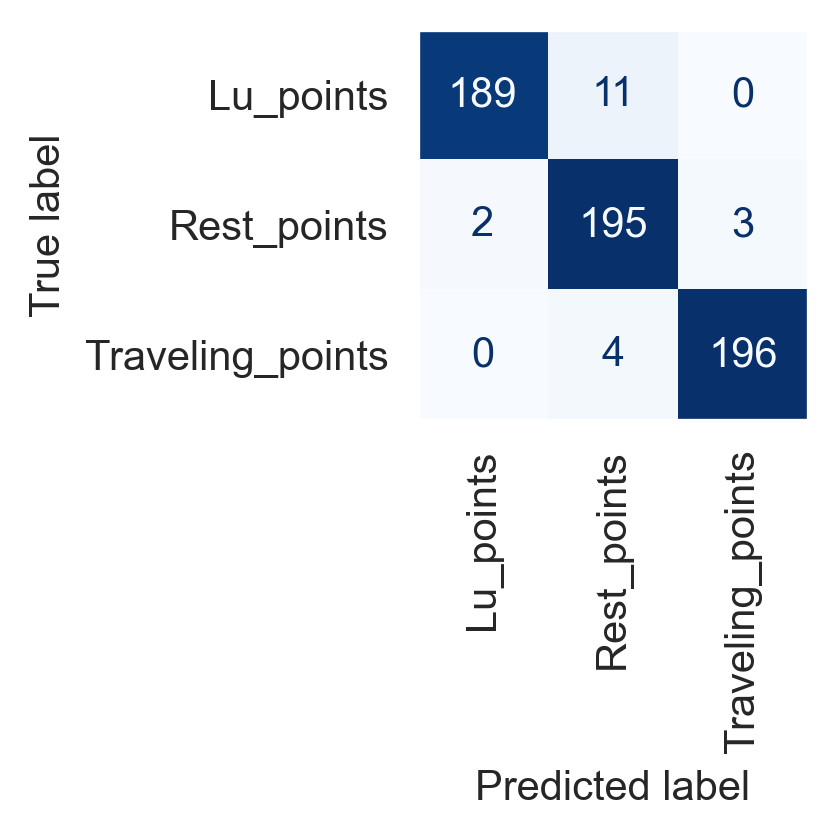

In [68]:
# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_model, display_labels=classes)

# Visualize the confusion matrix using the ConfusionMatrixDisplay object
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
disp.plot(
    include_values=True,
    cmap="Blues",
    ax=ax,
    xticks_rotation="horizontal",
    values_format="d",
    colorbar=False
)
tick_marks = np.arange(len(classes))
plt.tight_layout()
plt.xticks(tick_marks, classes, rotation=90)
ax.grid(False)

plt.savefig('./confusion_resnet50.svg', dpi=300,bbox_inches='tight')
plt.show()